## Multivariable Regression

### Prepared by Robin Fladebo     December 2018

### Introduction

Prepare FBI Uniform Crime Reporting data, for the State of New York for 2013, for use in a model with multivariable regression (including data cleaning if necessary) according to this specification:

Propertycrime=α+Population+Population^2+Murder+Robbery

The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. Don't forget basic data cleaning procedures. Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

#### Notes on data content

Property crime includes burglary, larceny-theft and vehicle theft.
Data can be retrieved here: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

Violent crime includes murder, non-negligent homicide, rape, robbery and aggravated assault.

### Data preparation

In [187]:
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline
import seaborn as sns

In [188]:
from sklearn import linear_model
import statsmodels.formula.api as smf

In [189]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [190]:
df = pd.read_excel('../Datafiles/fbi_nyc_2013.xlsx',sheet_name='fbi_nyc_2013')

In [191]:
df.shape

(351, 13)

In [192]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson'],
      dtype='object')

In [193]:
df.dtypes

City                                       object
Population                                float64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2               float64
Robbery                                   float64
Aggravated\nassault                       float64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson                                     float64
dtype: object

In [194]:
df.rename(columns=lambda x: x.replace('\n', '_'), inplace=True)

In [195]:
df.rename(columns=lambda x: x.lower(), inplace=True)

In [196]:
df.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def'}, inplace=True)

In [197]:
df.rename(columns={'murder and_nonnegligent_manslaughter':'murder'}, inplace=True)

In [198]:
df.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def', 'larceny-_theft':'larceny_theft'}, inplace=True)

In [199]:
# Drop any column that is filled with NA values
df.dropna(how='all', axis=1, inplace=True)

In [200]:
# Keep rows with at least 2 non-NA values (i.e., drop Notes rows)
df.dropna(how='any', thresh=2, inplace=True)

In [201]:
df['pop_sq'] = df['population']**2

In [202]:
df['pop_log'] = np.log(df['population'])

In [203]:
df['pty_crime_sqrt'] = np.sqrt(df['property_crime'])

In [204]:
def set_ind(var,new_val):
    df[new_val]=np.where(df[var]>0, 1, 0)
    return df
df = set_ind('murder', 'murder_ind')
df = set_ind('robbery', 'robbery_ind')

In [205]:
df['outlier_flag'] = np.where(df['population']>200000, 1, 0)

In [206]:
df['low_outlier'] = np.where(df['population']<5000, 1, 0 )

In [207]:
df.groupby(df['outlier_flag']).count()

,city,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,pop_sq,pop_log,pty_crime_sqrt,murder_ind,robbery_ind,outlier_flag,low_outlier
outlier_flag,,,,,,,,,,,,,,,,,,,
0,345,345,345,345,345,345,345,345,345,345,345,186,345,345,345,345,345,345,345
1,3,3,3,3,3,3,3,3,3,3,3,1,3,3,3,3,3,3,3


In [208]:
df.groupby(df['low_outlier']).count()

,city,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,pop_sq,pop_log,pty_crime_sqrt,murder_ind,robbery_ind,outlier_flag
low_outlier,,,,,,,,,,,,,,,,,,
0,215,215,215,215,215,215,215,215,215,215,215,103,215,215,215,215,215,215
1,133,133,133,133,133,133,133,133,133,133,133,84,133,133,133,133,133,133


In [209]:
# df.drop(df[df['outlier_flag'] == 1].index, inplace=True)

In [210]:
# df.drop(df[df['low_outlier'] == 1].index, inplace=True)

### Visual analysis

In [211]:
df.describe()

,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,pop_sq,pop_log,pty_crime_sqrt,murder_ind,robbery_ind,outlier_flag,low_outlier
count,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,187.000000,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4.003763e+04,201.594828,1.566092,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.871658,2.035547e+11,8.956080,15.502254,0.140805,0.600575,0.008621,0.382184
std,4.500374e+05,2815.268504,18.303673,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,10.693411,3.778876e+12,1.245456,23.534614,0.348321,0.490486,0.092580,0.486621
min,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.766760e+05,6.265301,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000,9.018117e+06,8.007361,6.363593,0.000000,0.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000,5.232568e+07,8.886458,10.606576,0.000000,1.000000,0.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,1.000000,3.397536e+08,9.821338,18.466185,0.000000,1.000000,0.000000,1.000000
max,8.396126e+06,52384.000000,335.000000,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000,7.049493e+13,15.943281,376.790393,1.000000,1.000000,1.000000,1.000000


In [212]:
df['qrtl_1']=np.where(df['population']<3004, 1, 0)
df['qrtl_2']=np.where((df['population']>3003) & (df['population']<7234), 1, 0)
df['qrtl_3']=np.where((df['population']>7233) & (df['population']<184270), 1, 0)
df['qrtl_4']=np.where(df['population']>184271, 1, 0)

In [257]:
#compute per capita measures for each variable in use
df['pty_crime_pc']=df['property_crime']/df['population']
df['murder_pc']=df['murder']/df['population']
df['robbery_pc']=df['robbery']/df['population']
df['violent_pc']=df['violent_crime']/df['population']

In [262]:
def set_ind(var,new_val):
    df[new_val]=np.where(df[var]>=0, 1, 0)
    return df
df = set_ind('murder_pc', 'murder_pc_ind')
df = set_ind('robbery_pc', 'robbery_pc_ind')
df = set_ind('violent_pc', 'violent_pc_ind')

In [272]:
df.corr()

,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,qrtl_2,qrtl_3,qrtl_4,pty_crime_pc,murder_pc,robbery_pc,violent_pc,murder_pc_ind,robbery_pc_ind,violent_pc_ind
population,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.996265,0.970578,0.997946,0.992421,...,-0.045165,-0.032320,0.534164,0.001928,0.071966,0.179951,0.150650,NaN,NaN,NaN
violent_crime,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.998059,0.978150,0.998762,0.996271,...,-0.040047,-0.048290,0.555900,0.011203,0.090707,0.203405,0.173627,NaN,NaN,NaN
murder,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.995403,0.993733,0.993175,0.997992,...,-0.048381,-0.048511,0.624989,0.033494,0.168857,0.272932,0.229579,NaN,NaN,NaN
rape_legacy_def,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.997843,0.992442,0.996260,0.998764,...,-0.050510,-0.036779,0.603397,0.042108,0.142150,0.261975,0.228772,NaN,NaN,NaN
robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.998237,0.979525,0.998735,0.996927,...,-0.040218,-0.049942,0.563185,0.011034,0.093640,0.207383,0.174946,NaN,NaN,NaN
aggravated_assault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.997622,0.976288,0.998561,0.995403,...,-0.039469,-0.047680,0.548870,0.009967,0.086241,0.198107,0.170213,NaN,NaN,NaN
property_crime,0.996265,0.998059,0.995403,0.997843,0.998237,0.997622,1.000000,0.987137,0.999666,0.998302,...,-0.052452,-0.027798,0.577005,0.036642,0.115395,0.235383,0.200196,NaN,NaN,NaN
burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,0.987137,1.000000,0.982700,0.991464,...,-0.064295,-0.023118,0.660873,0.075446,0.196761,0.336518,0.287207,NaN,NaN,NaN
larceny_theft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.999666,0.982700,1.000000,0.996878,...,-0.050835,-0.027396,0.561444,0.031368,0.102339,0.218963,0.186257,NaN,NaN,NaN
motor_vehicle_theft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.998302,0.991464,0.996878,1.000000,...,-0.048823,-0.043836,0.608459,0.029295,0.130010,0.253234,0.212673,NaN,NaN,NaN


In [270]:
# Create a dataframe with per capita values, used in model iteration 7
df_pc = df.filter(['pty_crime_pc','murder_pc','robbery_pc', 'violent_pc'])

In [271]:
print(df_pc.corr())

              pty_crime_pc  murder_pc  robbery_pc  violent_pc
pty_crime_pc      1.000000   0.209125    0.419695    0.531994
murder_pc         0.209125   1.000000    0.639665    0.598396
robbery_pc        0.419695   0.639665    1.000000    0.862699
violent_pc        0.531994   0.598396    0.862699    1.000000


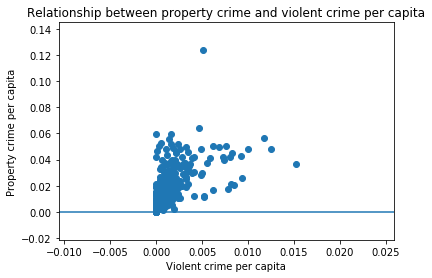

In [289]:
#Scatterplot property crime, violent crime per capita
plt.scatter(df['violent_pc'], df['pty_crime_pc'])
plt.xlabel('Violent crime per capita')
plt.ylabel('Property crime per capita')
plt.axhline(y=0)
plt.title('Relationship between property crime and violent crime per capita')
plt.show()

#### Clearly there are outlier values in the predictor population. A histogram of population consists of two visible bars and an outlier representing three large cities.

Text(0.5,1,'Frequency distribution of population of reporting cities in FBI UCR data - New York State')

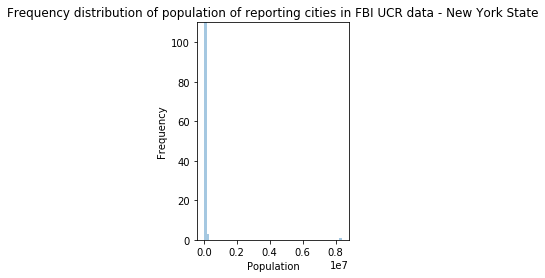

In [216]:
#Review the population distribution
plt.subplot(1, 2, 1)
plt.ylim(0,110)
sns.distplot(df.population, kde=False)
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.title('Frequency distribution of population of reporting cities in FBI UCR data - New York State')

#### Review the distribution of the log of population. I am using the log of population value to make the figure more readable.

Text(0.5,1,'Frequency distribution of log of population of reporting cities in FBI UCR data - New York State')

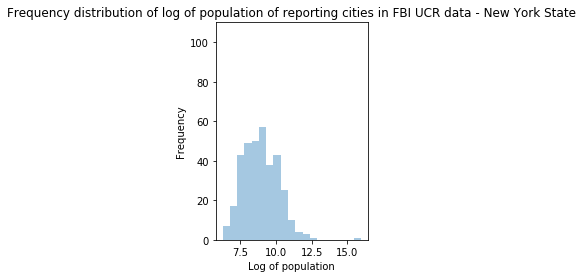

In [217]:
#Review the log of population distribution
plt.subplot(1, 2, 1)
plt.ylim(0,110)
sns.distplot(df.pop_log, kde=False)
plt.xlabel('Log of population')
plt.ylabel('Frequency')
plt.title('Frequency distribution of log of population of reporting cities in FBI UCR data - New York State')

In [218]:
# Create a minimal dataframe for the first iteration of the model
df_m1 = df.filter(['population', 'pop_sq','murder_ind','robbery_ind', 'property_crime'])

In [219]:
df_m1.describe()

,population,pop_sq,murder_ind,robbery_ind,property_crime
count,3.480000e+02,3.480000e+02,348.000000,348.000000,348.000000
mean,4.003763e+04,2.035547e+11,0.140805,0.600575,792.606322
std,4.500374e+05,3.778876e+12,0.348321,0.490486,7659.724746
min,5.260000e+02,2.766760e+05,0.000000,0.000000,0.000000
25%,3.003000e+03,9.018117e+06,0.000000,0.000000,40.500000
50%,7.233500e+03,5.232568e+07,0.000000,1.000000,112.500000
75%,1.842750e+04,3.397536e+08,0.000000,1.000000,341.000000
max,8.396126e+06,7.049493e+13,1.000000,1.000000,141971.000000


In [220]:
print(df_m1.corr())

                population    pop_sq  murder_ind  robbery_ind  property_crime
population        1.000000  0.998264    0.162309     0.064371        0.996265
pop_sq            0.998264  1.000000    0.133067     0.043983        0.991027
murder_ind        0.162309  0.133067    1.000000     0.313271        0.190670
robbery_ind       0.064371  0.043983    0.313271     1.000000        0.079318
property_crime    0.996265  0.991027    0.190670     0.079318        1.000000


#### None of the variables appear to be highly correlated with each other.

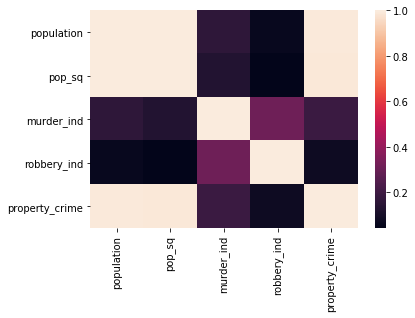

In [221]:
sns.heatmap(corrmap)

### Running the model and verifying assumptions

The R-squared value seems too good to be true. Heteroscedasticity violates an assumption for a linear regression model and is discussed below.

The variable with the highest predictive value in the first iteration of the model is the murder categorical variable.

In [222]:
# Instantiate and fit the first iteration (m1) of the model.
m1 = linear_model.LinearRegression()
Y = df_m1['property_crime'].values.reshape(-1, 1)
X = df_m1[['population','pop_sq','murder_ind', 'robbery_ind']]
m1.fit(X, Y)

print('\nCoefficients: \n', m1.coef_)
print('\nIntercept: \n', m1.intercept_)
print('\nR-squared:')
print(m1.score(X, Y))


Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

Intercept: 
 [-109.57533562]

R-squared:
0.9961247104988709


#### Check linear relationship

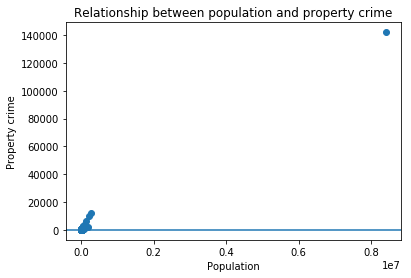

In [223]:
#Scatterplot population v property crime
plt.scatter(df_m1['population'], df_m1['property_crime'])
plt.xlabel('Population')
plt.ylabel('Property crime')
plt.axhline(y=0)
plt.title('Relationship between population and property crime')
plt.show()

#### Check multivariate normality by examining the distribution of errors

There are outliers in the error on both the low and high ends. This could be related to outliers in the underlying data; either in population, or property crime, or both.

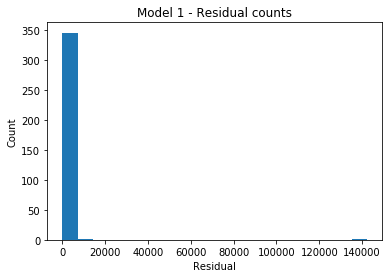

In [287]:
# Extract predicted values.
predicted = m1.predict(X).ravel()
actual = df_m1['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted
df_m1['residual'] = residual

plt.hist(df_m1['residual'], bins=20)
plt.title('Model 1 - Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [225]:
df_m1['residual'].describe()

count    3.480000e+02
mean     1.110733e-13
std      4.768318e+02
min     -4.259013e+03
25%     -8.904525e+01
50%      5.328805e+01
75%      1.322169e+02
max      3.854192e+03
Name: residual, dtype: float64

#### Check assumption of homoscedascity

There is higher error for both high and low outcomes in model 1.

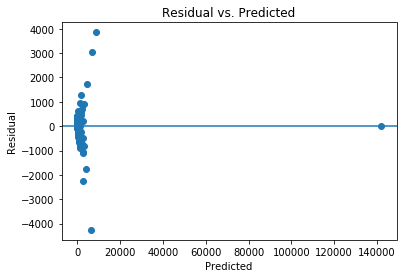

In [226]:
#Plot residual v predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### Check correlations among features (multicolinearity)

As shown in an earlier figure, the features do not appear to be highly correlated with one another (except as expected, for population and population squared).

In [227]:
correlation_matrix = X.corr()
display(correlation_matrix)

,population,pop_sq,murder_ind,robbery_ind
population,1.000000,0.998264,0.162309,0.064371
pop_sq,0.998264,1.000000,0.133067,0.043983
murder_ind,0.162309,0.133067,1.000000,0.313271
robbery_ind,0.064371,0.043983,0.313271,1.000000


### Fixing assumptions

#### Heteroscedasticity can be corrected by transforming the dependent variable and/or adding features in poorly estimated areas. Heteroscedasticity can result in over-confidence in the model predictions. I am going to test correcting for heteroscedasticity by transforming the dependent variable, property crime, by taking its square root.

In [228]:
df_m2 = df.filter(['population', 'pop_sq','murder_ind','robbery_ind', 'pty_crime_sqrt'])

In [229]:
m2 = linear_model.LinearRegression()
Y = df_m2['pty_crime_sqrt'].values.reshape(-1, 1)
X = df_m2[['population','pop_sq','murder_ind', 'robbery_ind']]
m2.fit(X, Y)

print('\nCoefficients: \n', m2.coef_)
print('\nIntercept: \n', m2.intercept_)
print('\nR-squared:')
print(m2.score(X, Y))


Coefficients: 
 [[ 3.80096080e-04 -4.01266025e-11  3.87190536e+00  5.97991361e+00]]

Intercept: 
 [4.31549675]

R-squared:
0.9500188877037536


I now have a positive intercept and the violent crime indicators both have predictive value. The R-squared seems more reasonable (that is, it doesn't seem as if accuracy is as seriously over-estimated as in iteration 1).

#### Multivariate non-normality results in mis-estimation. It can be corrected by dealing with outliers. I will iterate the model two times by first excluding the high outliers, then the low outliers based on population. I am going to keep the transformation of property crime to the square root.

Dropping the high population outliers (iteration 3, below) is probably not an improvement.

In [230]:
df_m3 = df.filter(['population', 'pop_sq','murder_ind','robbery_ind', 'pty_crime_sqrt', 'outlier_flag'])

In [231]:
df_m3.drop(df_m3[df_m3['outlier_flag'] == 1].index, inplace=True)

In [232]:

m3 = linear_model.LinearRegression()
Y = df_m3['pty_crime_sqrt'].values.reshape(-1, 1)
X = df_m3[['population','pop_sq','murder_ind', 'robbery_ind']]
m3.fit(X, Y)

print('\nCoefficients: \n', m3.coef_)
print('\nIntercept: \n', m3.intercept_)
print('\nR-squared:')
print(m3.score(X, Y))


Coefficients: 
 [[ 5.83830385e-04 -1.78462812e-09  2.92378733e+00  4.50697697e+00]]

Intercept: 
 [3.46744594]

R-squared:
0.8234907254831821


Dropping both the high and low population outliers (below) does not improve the model.

In [233]:
df_m4 = df.filter(['population', 'pop_sq','murder_ind','robbery_ind', 'pty_crime_sqrt', 'outlier_flag', 'low_outlier'])
df_m4.drop(df_m4[df_m4['outlier_flag'] == 1].index, inplace=True)
df_m4.drop(df_m4[df_m4['low_outlier'] == 1].index, inplace=True)

In [234]:
m4 = linear_model.LinearRegression()
Y = df_m4['pty_crime_sqrt'].values.reshape(-1, 1)
X = df_m4[['population','pop_sq','murder_ind', 'robbery_ind']]
m4.fit(X, Y)

print('\nCoefficients: \n', m4.coef_)
print('\nIntercept: \n', m4.intercept_)
print('\nR-squared:')
print(m4.score(X, Y))


Coefficients: 
 [[ 5.72236670e-04 -1.72077565e-09  2.91565339e+00  5.01142089e+00]]

Intercept: 
 [3.2659378]

R-squared:
0.7653976310528735


Dropping the rows with property crime equal to zero results in a minor improvement in R-squared.

In [235]:
df_m5 = df.filter(['population', 'pop_sq','murder_ind','robbery_ind', 'pty_crime_sqrt', 'property_crime'])
df_m5.drop(df_m5[df_m5['property_crime'] == 0].index, inplace=True)

In [236]:
m5 = linear_model.LinearRegression()
Y = df_m5['pty_crime_sqrt'].values.reshape(-1, 1)
X = df_m5[['population','pop_sq','murder_ind', 'robbery_ind']]
m5.fit(X, Y)

print('\nCoefficients: \n', m5.coef_)
print('\nIntercept: \n', m5.intercept_)
print('\nR-squared:')
print(m5.score(X, Y))


Coefficients: 
 [[ 3.79561635e-04 -4.00632569e-11  3.88414493e+00  5.77107738e+00]]

Intercept: 
 [4.53405993]

R-squared:
0.9503900294517691


Adding indicators for the first and fourth quartiles in population improves the model slightly.

In [237]:
df_m6 = df.filter(['population', 'pop_sq','murder_ind','robbery_ind', 'pty_crime_sqrt', 'property_crime', 'qrtl_1', 'qrtl_4'])
df_m6.drop(df_m6[df_m6['property_crime'] == 0].index, inplace=True)

In [238]:
m6 = linear_model.LinearRegression()
Y = df_m6['pty_crime_sqrt'].values.reshape(-1, 1)
X = df_m6[['population','pop_sq','murder_ind', 'robbery_ind', 'qrtl_1', 'qrtl_4']]
m6.fit(X, Y)

print('\nCoefficients: \n', m6.coef_)
print('\nIntercept: \n', m6.intercept_)
print('\nR-squared:')
print(m6.score(X, Y))


Coefficients: 
 [[ 4.36796820e-04 -4.65638145e-11  3.08147446e+00  4.52938784e+00
  -1.52587885e+00 -2.07337107e+01]]

Intercept: 
 [5.02768989]

R-squared:
0.9543498634303469


Per capita measures are often used when analyzing data of this type. But the way I have it constructed, they do not result in a better model.

In [277]:
df_m7 = df.filter(['pty_crime_pc', 'murder_pc', 'murder_ind', 'robbery_pc', 'robbery_ind', 'violent_pc', 'qrtl_3', 'qrtl_4'])

In [279]:
m7 = linear_model.LinearRegression()
Y = df_m7['pty_crime_pc'].values.reshape(-1, 1)
X = df_m7[['robbery_pc', 'murder_pc', 'qrtl_3', 'qrtl_4']]
m7.fit(X, Y)

print('\nCoefficients: \n', m7.coef_)
print('\nIntercept: \n', m7.intercept_)
print('\nR-squared:')
print(m7.score(X, Y))


Coefficients: 
 [[ 1.11708803e+01 -3.93024670e+01 -6.75763027e-04 -1.89076764e-02]]

Intercept: 
 [0.01625283]

R-squared:
0.19640408493122685


### Discussion and summary: Feature engineering and selection